# ArXiv Dataset: Exploratory Data Analysis & Sampling Strategy

**Author**: Aleksandar Georgiev
**Date**: January 2026  
**Purpose**: Comprehensive EDA to inform model architecture and training decisions

---

## Summary

This notebook performs a rigorous analysis of the ArXiv dataset to answer key questions:

1. **Problem Formulation**: Is this multi-class or multi-label classification?
2. **Class Distribution**: How severe is the imbalance? Which categories are viable?
3. **Text Characteristics**: What preprocessing does BERT actually need?
4. **Sampling Strategy**: How to create a balanced, representative training set?
5. **Data Quality**: Missing values, duplicates, anomalies?

**Key Findings** (populated after analysis):
- Dataset size: ~2.9M papers
- Multi-label: 47.7% of papers have 2+ categories
- Extreme imbalance: Top 10 categories contain ~50% of papers
- Abstract length: 95th percentile ~300 tokens (fits BERT's 512 limit)


## 1. Environment Setup

In [ ]:
import os
import json
import hashlib
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Optional, Iterator
from dataclasses import dataclass
import itertools
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import re
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict, Features, Value, Sequence, load_from_disk

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

PROJECT_ROOT = Path('../')
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
HF_DATASET_DIR = DATA_DIR / 'hf_dataset'  # New: HF dataset directory
FIGURES_DIR = PROJECT_ROOT / 'notebooks' / 'figures'

for dir_path in [RAW_DATA_DIR, PROCESSED_DATA_DIR, HF_DATASET_DIR, FIGURES_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT.resolve()}")
print(f"Data directory: {DATA_DIR.resolve()}")
print(f"HF Dataset directory: {HF_DATASET_DIR.resolve()}")

Project root: /Users/alex/projects/arxiv-classifier-system
Data directory: /Users/alex/projects/arxiv-classifier-system/data
HF Dataset directory: /Users/alex/projects/arxiv-classifier-system/data/hf_dataset


## 2. Data Acquisition

### 2.1 Download from Kaggle

The ArXiv dataset is hosted on Kaggle (~4GB compressed). You'll need:
1. A Kaggle account
2. Kaggle API credentials (`~/.kaggle/kaggle.json`)

In [ ]:
# Download dataset (run once)
ARXIV_JSON_PATH = RAW_DATA_DIR / 'arxiv-metadata-oai-snapshot.json'

if not ARXIV_JSON_PATH.exists():
    print("Downloading ArXiv dataset from Kaggle...")
    print("This may take 5-10 minutes depending on connection speed.")
    
    # Using subprocess for better control
    import subprocess
    
    result = subprocess.run(
        [
            'kaggle', 'datasets', 'download',
            '-d', 'Cornell-University/arxiv',
            '-p', str(RAW_DATA_DIR),
            '--unzip'
        ],
        capture_output=True,
        text=True
    )
    
    if result.returncode != 0:
        print(f"Error: {result.stderr}")
        print("\nManual download instructions:")
        print("1. Go to: https://www.kaggle.com/datasets/Cornell-University/arxiv")
        print("2. Click 'Download' button")
        print(f"3. Extract to: {RAW_DATA_DIR}")
    else:
        print(f"Downloaded successfully to {RAW_DATA_DIR}")
else:
    print(f"Dataset already exists at {ARXIV_JSON_PATH}")
    print(f"File size: {ARXIV_JSON_PATH.stat().st_size / 1e9:.2f} GB")

Dataset already exists at ../data/raw/arxiv-metadata-oai-snapshot.json
File size: 5.05 GB


### 2.2 Memory-Efficient Data Loading

**Critical Decision**: The full dataset is ~4GB JSON. Loading it all into memory is:
- Wasteful (we only need `abstract` and `categories`)
- Slow (JSON parsing is expensive)
- Risky (OOM on smaller machines)


In [10]:
@dataclass
class ArxivPaper:
    """Minimal representation of an ArXiv paper for classification."""
    id: str
    title: str
    abstract: str
    categories: List[str]  # Can have multiple
    primary_category: str  # First listed category
    update_date: str
    
    @property
    def domain(self) -> str:
        """Extract domain from primary category (e.g., 'cs' from 'cs.LG')"""
        return self.primary_category.split('.')[0] if '.' in self.primary_category else self.primary_category
    
    @property
    def is_multilabel(self) -> bool:
        return len(self.categories) > 1


def stream_arxiv_papers(
    filepath: Path,
    max_papers: Optional[int] = None,
    min_abstract_length: int = 100,
    progress: bool = True
) -> Iterator[ArxivPaper]:
    """
    Stream ArXiv papers from JSON file with filtering.
    
    Memory efficient: yields one paper at a time.
    
    Args:
        filepath: Path to arxiv-metadata-oai-snapshot.json
        max_papers: Optional limit on number of papers to yield
        min_abstract_length: Skip papers with shorter abstracts
        progress: Show progress bar
    
    Yields:
        ArxivPaper objects
    """
    count = 0
    skipped = {'no_abstract': 0, 'short_abstract': 0, 'no_categories': 0}
    
    # Estimate total lines for progress bar
    total_estimate = 2_500_000  # Approximately 2.3M papers
    
    with open(filepath, 'r', encoding='utf-8') as f:
        iterator = tqdm(f, total=total_estimate, desc="Loading papers") if progress else f
        
        for line in iterator:
            if max_papers and count >= max_papers:
                break
                
            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                continue
            
            # Validate required fields
            abstract = record.get('abstract', '').strip()
            if not abstract:
                skipped['no_abstract'] += 1
                continue
            
            if len(abstract) < min_abstract_length:
                skipped['short_abstract'] += 1
                continue
            
            categories_str = record.get('categories', '')
            if not categories_str:
                skipped['no_categories'] += 1
                continue
            
            # Parse categories (space-separated)
            categories = categories_str.split()
            
            # Clean abstract (remove excessive whitespace, newlines)
            abstract = ' '.join(abstract.split())
            
            yield ArxivPaper(
                id=record.get('id', ''),
                title=record.get('title', '').strip(),
                abstract=abstract,
                categories=categories,
                primary_category=categories[0],
                update_date=record.get('update_date', '')
            )
            
            count += 1
    
    if progress:
        print(f"\nLoaded {count:,} papers")
        print(f"Skipped: {skipped}")

### 2.3 Initial Data Scan

First pass: Collect statistics without loading everything into memory.

In [11]:
# First pass: Collect category statistics (memory efficient)
print("Scanning dataset for statistics...")
print("This will take 2-5 minutes.\n")

# Counters for statistics
category_counts = Counter()
primary_category_counts = Counter()
domain_counts = Counter()
labels_per_paper = Counter()  # How many labels does each paper have?
abstract_lengths = []  # Character lengths (sample)
years = Counter()

total_papers = 0
sample_rate = 10  # Sample every 10th paper for detailed stats

for paper in stream_arxiv_papers(ARXIV_JSON_PATH):
    total_papers += 1
    
    # Count all categories (for multi-label)
    for cat in paper.categories:
        category_counts[cat] += 1
    
    # Count primary categories (for multi-class baseline)
    primary_category_counts[paper.primary_category] += 1
    
    # Count domains
    domain_counts[paper.domain] += 1
    
    # Multi-label statistics
    labels_per_paper[len(paper.categories)] += 1
    
    # Sample abstract lengths (every 10th paper)
    if total_papers % sample_rate == 0:
        abstract_lengths.append(len(paper.abstract))
    
    # Year from update_date
    if paper.update_date:
        year = paper.update_date[:4]
        years[year] += 1

print(f"\n{'='*60}")
print(f"DATASET OVERVIEW")
print(f"{'='*60}")
print(f"Total papers:         {total_papers:,}")
print(f"Unique categories:    {len(category_counts)}")
print(f"Unique domains:       {len(domain_counts)}")
print(f"Year range:           {min(years.keys())} - {max(years.keys())}")

Scanning dataset for statistics...
This will take 2-5 minutes.



Loading papers:   0%|          | 0/2500000 [00:00<?, ?it/s]


Loaded 2,920,623 papers
Skipped: {'no_abstract': 0, 'short_abstract': 6840, 'no_categories': 0}

DATASET OVERVIEW
Total papers:         2,920,623
Unique categories:    176
Unique domains:       38
Year range:           2007 - 2026


## 3. Problem Formulation Analysis

### 3.1 Multi-Label vs Multi-Class

**Critical Question**: Should we treat this as:
- **Multi-class**: Each paper -> exactly one category (primary)
- **Multi-label**: Each paper -> one or more categories


The answer determines model architecture, loss function, and evaluation metrics.

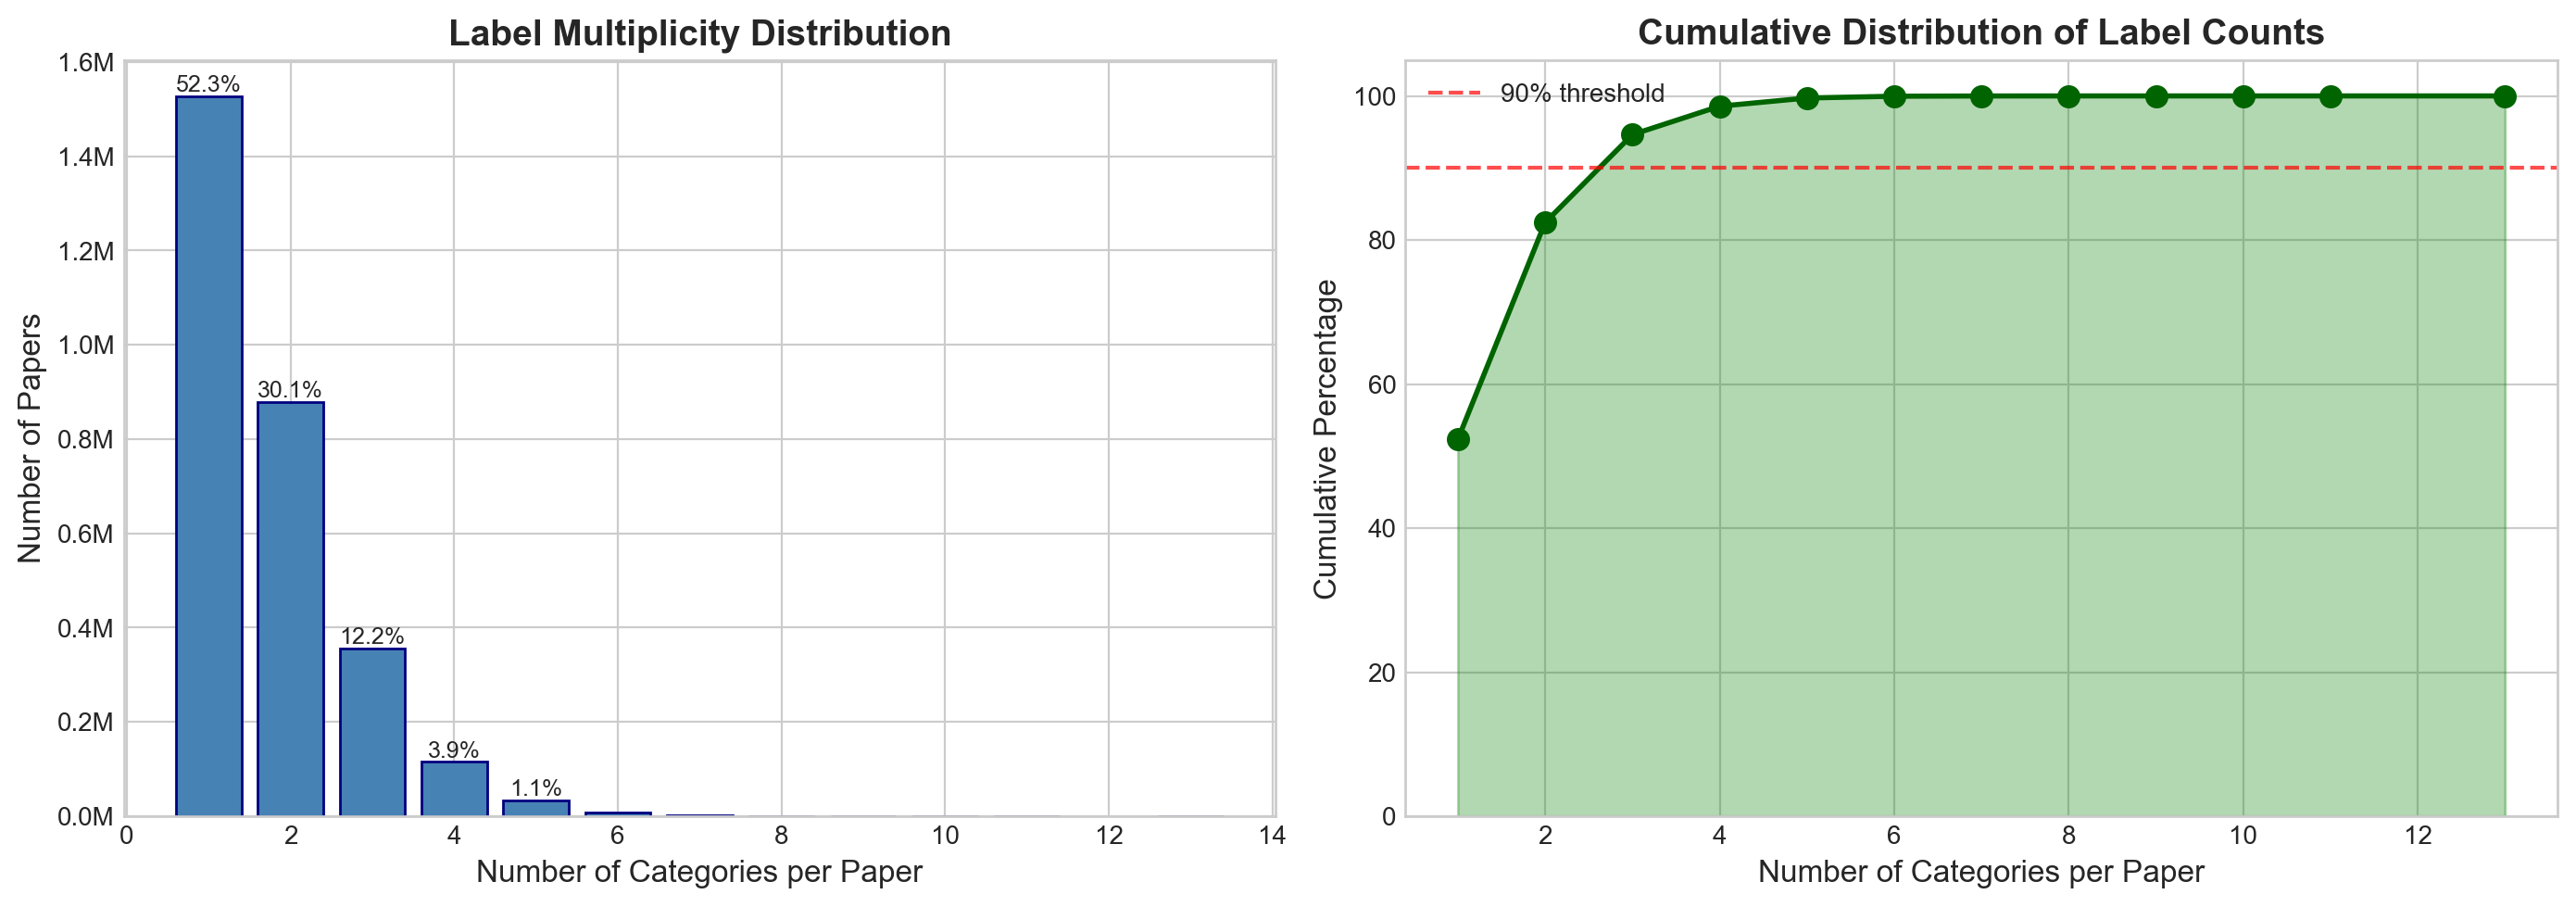


MULTI-LABEL ANALYSIS
Single-label papers:  1,527,845 (52.3%)
Multi-label papers:   1,392,778 (47.7%)

Avg labels per paper: 1.72
Max labels on a paper: 13


In [12]:
# Analyze label distribution per paper
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Distribution of labels per paper
labels_df = pd.DataFrame([
    {'num_labels': k, 'count': v, 'percentage': v/total_papers*100}
    for k, v in sorted(labels_per_paper.items())
])

ax1 = axes[0]
bars = ax1.bar(labels_df['num_labels'], labels_df['count'], color='steelblue', edgecolor='navy')
ax1.set_xlabel('Number of Categories per Paper', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12)
ax1.set_title('Label Multiplicity Distribution', fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Add percentage annotations
for bar, pct in zip(bars, labels_df['percentage']):
    if pct > 1:  # Only annotate > 1%
        ax1.annotate(f'{pct:.1f}%', 
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=9)

# Right: Cumulative distribution
ax2 = axes[1]
cumsum = labels_df['count'].cumsum() / total_papers * 100
ax2.plot(labels_df['num_labels'], cumsum, 'o-', color='darkgreen', linewidth=2, markersize=8)
ax2.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='90% threshold')
ax2.fill_between(labels_df['num_labels'], cumsum, alpha=0.3, color='green')
ax2.set_xlabel('Number of Categories per Paper', fontsize=12)
ax2.set_ylabel('Cumulative Percentage', fontsize=12)
ax2.set_title('Cumulative Distribution of Label Counts', fontsize=14, fontweight='bold')
ax2.legend()
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'label_multiplicity.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
single_label = labels_per_paper.get(1, 0)
multi_label = total_papers - single_label

print(f"\n{'='*60}")
print(f"MULTI-LABEL ANALYSIS")
print(f"{'='*60}")
print(f"Single-label papers:  {single_label:,} ({single_label/total_papers*100:.1f}%)")
print(f"Multi-label papers:   {multi_label:,} ({multi_label/total_papers*100:.1f}%)")
print(f"\nAvg labels per paper: {sum(k*v for k,v in labels_per_paper.items())/total_papers:.2f}")
print(f"Max labels on a paper: {max(labels_per_paper.keys())}")

### 3.2 Decision: Problem Formulation

Based on the analysis above:

In [13]:
multilabel_percentage = multi_label / total_papers * 100

print(f"""
PROBLEM FORMULATION DECISION
{'='*60}
Finding: {multilabel_percentage:.1f}% of papers have multiple categories

DECISION: MULTI-LABEL CLASSIFICATION

Rationale:
  - Significant portion ({multilabel_percentage:.0f}%) of papers belong to 2+ fields
  - Multi-class would discard valid label information
  - Cross-disciplinary papers (e.g., cs.LG + stat.ML) are important


""")


PROBLEM FORMULATION DECISION
Finding: 47.7% of papers have multiple categories

DECISION: MULTI-LABEL CLASSIFICATION

Rationale:
  - Significant portion (48%) of papers belong to 2+ fields
  - Multi-class would discard valid label information
  - Cross-disciplinary papers (e.g., cs.LG + stat.ML) are important





## 4. Category Analysis

### 4.1 Domain-Level Distribution

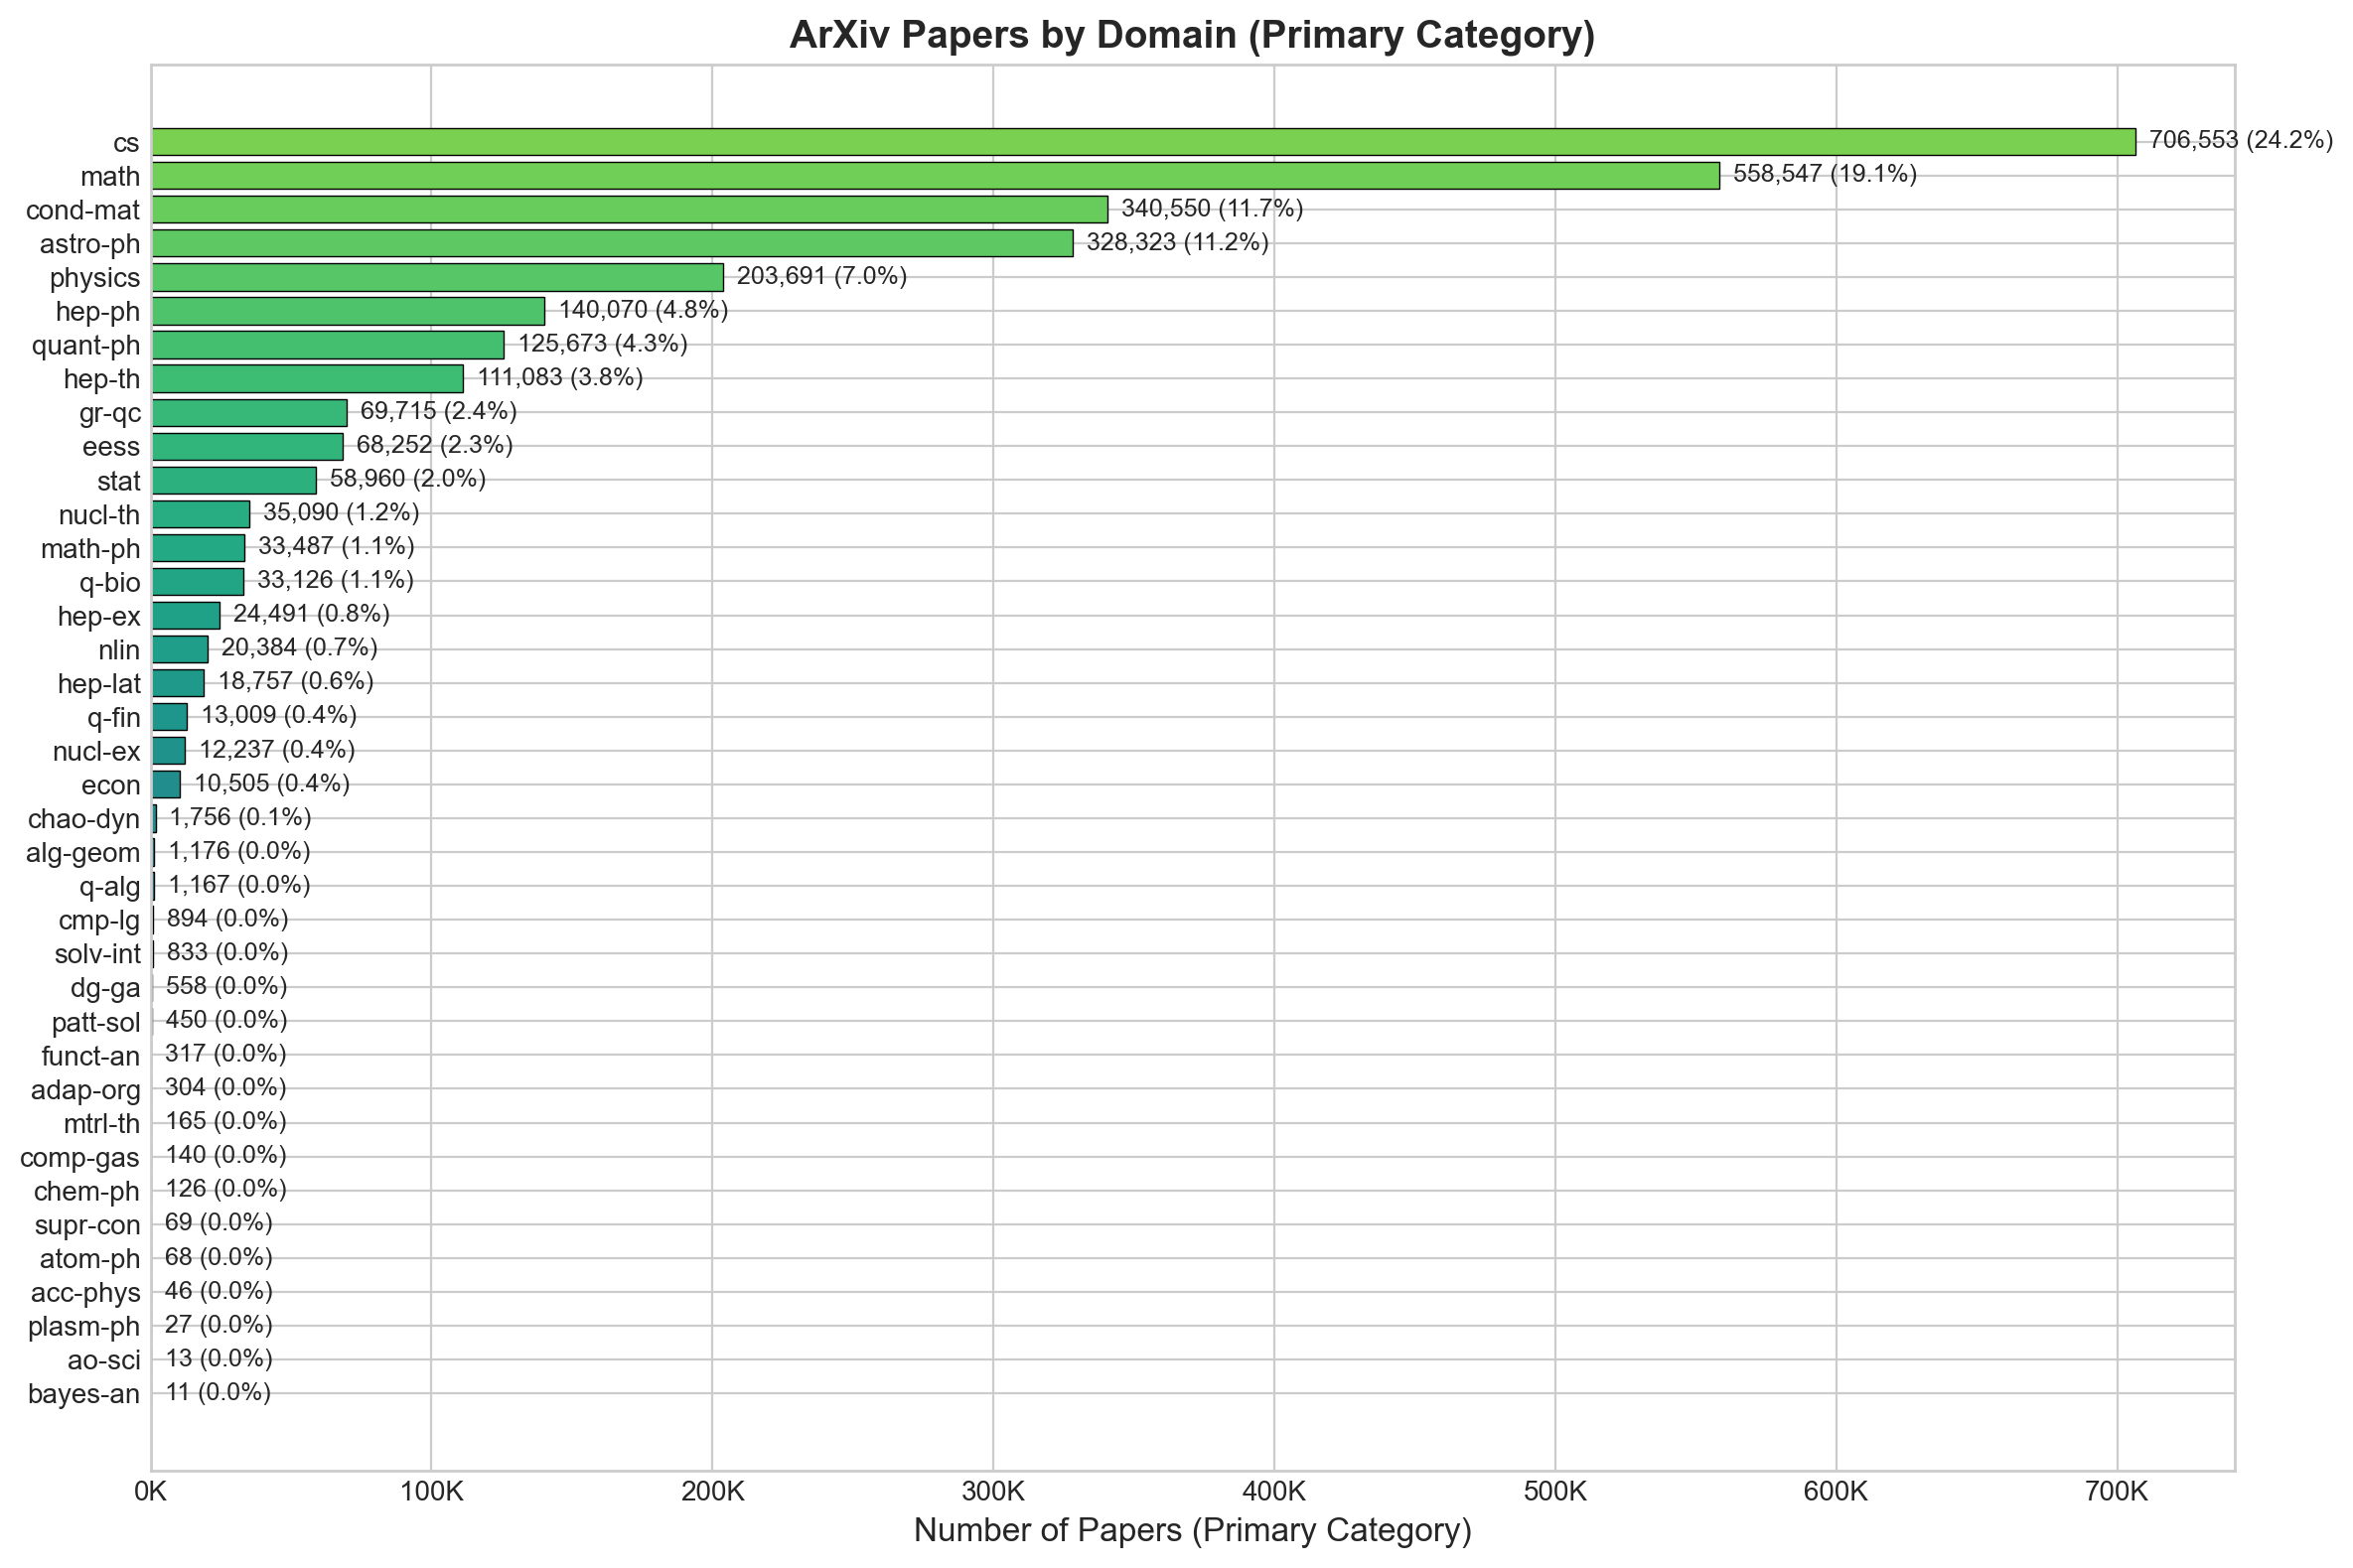


Top 5 Domains:
  cs          :    706,553 papers (24.2%)
  math        :    558,547 papers (19.1%)
  cond-mat    :    340,550 papers (11.7%)
  astro-ph    :    328,323 papers (11.2%)
  physics     :    203,691 papers (7.0%)


In [14]:
# Domain distribution
domain_df = pd.DataFrame([
    {'domain': d, 'count': c, 'percentage': c/total_papers*100}
    for d, c in domain_counts.most_common()
]).sort_values('count', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(domain_df)))
bars = ax.barh(domain_df['domain'], domain_df['count'], color=colors, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Number of Papers (Primary Category)', fontsize=12)
ax.set_title('ArXiv Papers by Domain (Primary Category)', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

# Add count labels
for bar, count, pct in zip(bars, domain_df['count'], domain_df['percentage']):
    ax.annotate(f'{count:,} ({pct:.1f}%)', 
                xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                ha='left', va='center', fontsize=9, xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'domain_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 5 Domains:")
for _, row in domain_df.tail(5).iloc[::-1].iterrows():
    print(f"  {row['domain']:12s}: {row['count']:>10,} papers ({row['percentage']:.1f}%)")

### 4.2 Category-Level Distribution (The Long Tail Problem)

In [15]:
# Create dataframe of all categories
category_df = pd.DataFrame([
    {
        'category': cat,
        'count': count,
        'domain': cat.split('.')[0] if '.' in cat else cat
    }
    for cat, count in category_counts.most_common()
])

category_df['percentage'] = category_df['count'] / category_df['count'].sum() * 100
category_df['cumulative_pct'] = category_df['percentage'].cumsum()

print(f"Total unique categories: {len(category_df)}")
print(f"\nTop 20 Categories:")
print(category_df.head(20).to_string(index=False))

Total unique categories: 176

Top 20 Categories:
          category  count   domain  percentage  cumulative_pct
             cs.LG 247718       cs    4.919503        4.919503
            hep-ph 192450   hep-ph    3.821920        8.741424
            hep-th 178756   hep-th    3.549967       12.291391
             cs.CV 178523       cs    3.545340       15.836730
          quant-ph 172383 quant-ph    3.423404       19.260134
             cs.AI 157334       cs    3.124541       22.384676
             gr-qc 118603    gr-qc    2.355371       24.740047
 cond-mat.mtrl-sci 105342 cond-mat    2.092017       26.832064
          astro-ph 105209 astro-ph    2.089376       28.921440
             cs.CL  99618       cs    1.978343       30.899783
 cond-mat.mes-hall  98990 cond-mat    1.965871       32.865654
           math-ph  87442  math-ph    1.736536       34.602190
           math.MP  87442     math    1.736536       36.338726
   cond-mat.str-el  80867 cond-mat    1.605961       37.944687
cond-m

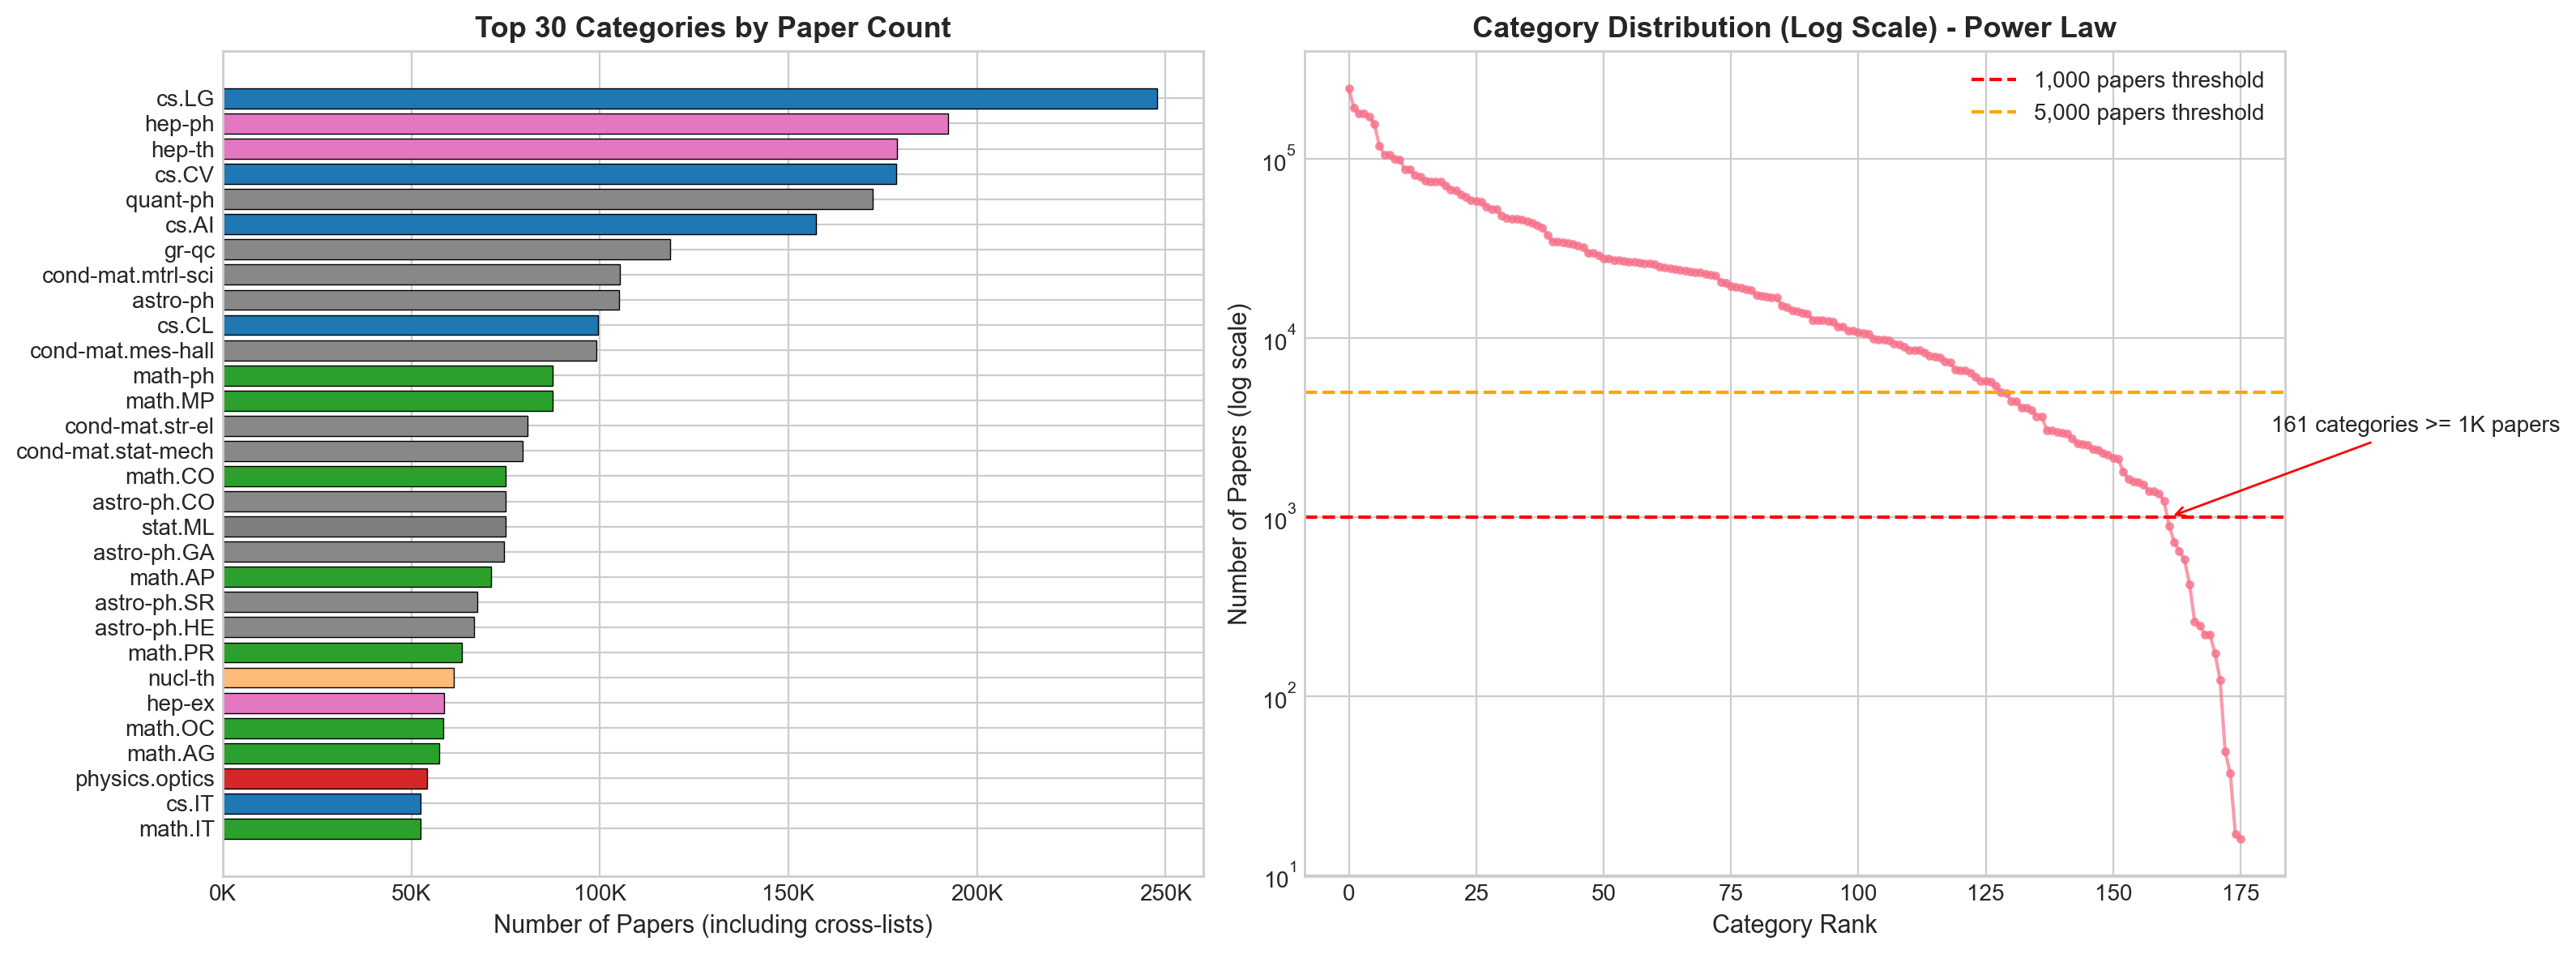


CLASS IMBALANCE ANALYSIS
Categories with >= 10,000 papers: 103
Categories with >= 5,000 papers:  128
Categories with >= 1,000 papers:  161
Categories with < 1,000 papers:  15

Imbalance ratio (max/min): 247,718 / 16 = 15482x


In [16]:
# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Top 30 categories
ax1 = axes[0]
top_30 = category_df.head(30).sort_values('count', ascending=True)

# Color by domain
domain_colors = {
    'cs': '#1f77b4', 'math': '#2ca02c', 'physics': '#d62728', 
    'astro-ph': '#9467bd', 'cond-mat': '#8c564b', 'hep': '#e377c2',
    'stat': '#7f7f7f', 'quant-ph': '#bcbd22', 'q-bio': '#17becf',
    'eess': '#ff7f0e', 'gr-qc': '#aec7e8', 'nucl': '#ffbb78'
}

bar_colors = [domain_colors.get(d.split('-')[0], '#888888') for d in top_30['domain']]
bars = ax1.barh(top_30['category'], top_30['count'], color=bar_colors, edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Number of Papers (including cross-lists)', fontsize=11)
ax1.set_title('Top 30 Categories by Paper Count', fontsize=13, fontweight='bold')
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e3:.0f}K'))

# Right: Log scale showing full distribution
ax2 = axes[1]
ax2.semilogy(range(len(category_df)), category_df['count'], 'o-', markersize=3, alpha=0.7)
ax2.axhline(y=1000, color='red', linestyle='--', label='1,000 papers threshold')
ax2.axhline(y=5000, color='orange', linestyle='--', label='5,000 papers threshold')
ax2.set_xlabel('Category Rank', fontsize=11)
ax2.set_ylabel('Number of Papers (log scale)', fontsize=11)
ax2.set_title('Category Distribution (Log Scale) - Power Law', fontsize=13, fontweight='bold')
ax2.legend()

# Add annotation for viable categories
viable_1k = sum(1 for c in category_df['count'] if c >= 1000)
viable_5k = sum(1 for c in category_df['count'] if c >= 5000)
ax2.annotate(f'{viable_1k} categories >= 1K papers', xy=(viable_1k, 1000), 
            xytext=(viable_1k+20, 3000), fontsize=10,
            arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'category_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print imbalance statistics
print(f"\n{'='*60}")
print(f"CLASS IMBALANCE ANALYSIS")
print(f"{'='*60}")
print(f"Categories with >= 10,000 papers: {sum(1 for c in category_df['count'] if c >= 10000)}")
print(f"Categories with >= 5,000 papers:  {sum(1 for c in category_df['count'] if c >= 5000)}")
print(f"Categories with >= 1,000 papers:  {sum(1 for c in category_df['count'] if c >= 1000)}")
print(f"Categories with < 1,000 papers:  {sum(1 for c in category_df['count'] if c < 1000)}")
print(f"\nImbalance ratio (max/min): {category_df['count'].max():,} / {category_df['count'].min():,} = {category_df['count'].max()/category_df['count'].min():.0f}x")

### 4.3 Category Selection Strategy

**Critical Decision**: Training on all 170+ categories is problematic:
- Extreme class imbalance (hep-th: 100K+ vs nlin.CG: <500)
- Many rare categories won't have enough training data
- Model will be biased toward majority classes


**Critical Decision**: Label granularity:
  - Domain only: First level of hierarchy (e.g., "cs", "stat")
  - Domain + subdomain: Full category (e.g., "cs.LG", "stat.ML")

DECISION: DOMAIN + SUBDOMAIN

Rationale:
  - More granular predictions are more useful
  - Domain-level results can be derived by aggregating subdomains
  - Future work: Compare model performance at domain-only level

In [17]:
def select_categories(
    category_df: pd.DataFrame,
    min_samples: int = 5000,
    max_categories: int = 50,
    ensure_domains: List[str] = None
) -> List[str]:
    """
    Select categories for training based on sample counts and domain coverage.
    
    Strategy:
    1. Filter by minimum sample threshold
    2. Ensure domain diversity (at least one from each major domain)
    3. Cap at max_categories to avoid extreme multi-label complexity
    
    Args:
        category_df: DataFrame with 'category', 'count', 'domain' columns
        min_samples: Minimum papers required per category
        max_categories: Maximum number of categories to include
        ensure_domains: List of domains that must have at least one category
    
    Returns:
        List of selected category names
    """
    ensure_domains = ensure_domains or ['cs', 'math', 'physics', 'stat', 'eess', 'q-bio']
    
    # Start with categories meeting threshold
    viable = category_df[category_df['count'] >= min_samples].copy()
    
    # Ensure domain coverage - add top category from under-represented domains
    selected_domains = set(viable['domain'])
    for domain in ensure_domains:
        if domain not in selected_domains:
            domain_cats = category_df[category_df['domain'] == domain]
            if len(domain_cats) > 0:
                top_cat = domain_cats.iloc[0]
                viable = pd.concat([viable, pd.DataFrame([top_cat])], ignore_index=True)
    
    # Sort by count and cap
    viable = viable.sort_values('count', ascending=False).head(max_categories)
    
    return viable['category'].tolist()


# Select categories with different thresholds for comparison
thresholds = [1000, 2000, 5000, 10000]

print("Category Selection Analysis:")
print("="*70)
for thresh in thresholds:
    selected = select_categories(category_df, min_samples=thresh, max_categories=50)
    domains = set(c.split('.')[0] if '.' in c else c for c in selected)
    total_papers_covered = category_df[category_df['category'].isin(selected)]['count'].sum()
    coverage = total_papers_covered / category_df['count'].sum() * 100
    print(f"Threshold {thresh:,}+ papers: {len(selected):2d} categories, {len(domains):2d} domains, {coverage:.1f}% coverage")

Category Selection Analysis:
Threshold 1,000+ papers: 50 categories, 15 domains, 73.9% coverage
Threshold 2,000+ papers: 50 categories, 15 domains, 73.9% coverage
Threshold 5,000+ papers: 50 categories, 15 domains, 73.9% coverage
Threshold 10,000+ papers: 50 categories, 15 domains, 73.9% coverage


In [42]:
# Final category selection
MIN_SAMPLES_THRESHOLD = 5000  # Enough for meaningful train/val/test splits
MAX_CATEGORIES = 50  # Manageable for multi-label

SELECTED_CATEGORIES = select_categories(
    category_df, 
    min_samples=MIN_SAMPLES_THRESHOLD, 
    max_categories=MAX_CATEGORIES
)

# Create lookup dataframe for selected categories
selected_df = category_df[category_df['category'].isin(SELECTED_CATEGORIES)].copy()
selected_df['selected'] = True

print(f"\n{'='*60}")
print(f"SELECTED CATEGORIES FOR TRAINING")
print(f"{'='*60}")
print(f"Total categories selected: {len(SELECTED_CATEGORIES)}")
print(f"Domains covered: {len(set(c.split('.')[0] if '.' in c else c for c in SELECTED_CATEGORIES))}")
print(f"\nCategories:")
for i, cat in enumerate(SELECTED_CATEGORIES, 1):
    count = category_df[category_df['category'] == cat]['count'].values[0]
    print(f"  {i:2d}. {cat:20s}: {count:>10,} papers")


SELECTED CATEGORIES FOR TRAINING
Total categories selected: 50
Domains covered: 15

Categories:
   1. cs.LG               :    247,718 papers
   2. hep-ph              :    192,450 papers
   3. hep-th              :    178,756 papers
   4. cs.CV               :    178,523 papers
   5. quant-ph            :    172,383 papers
   6. cs.AI               :    157,334 papers
   7. gr-qc               :    118,603 papers
   8. cond-mat.mtrl-sci   :    105,342 papers
   9. astro-ph            :    105,209 papers
  10. cs.CL               :     99,618 papers
  11. cond-mat.mes-hall   :     98,990 papers
  12. math-ph             :     87,442 papers
  13. math.MP             :     87,442 papers
  14. cond-mat.str-el     :     80,867 papers
  15. cond-mat.stat-mech  :     79,536 papers
  16. math.CO             :     75,116 papers
  17. astro-ph.CO         :     75,068 papers
  18. stat.ML             :     75,034 papers
  19. astro-ph.GA         :     74,651 papers
  20. math.AP             :  

In [18]:
# Final category selection
MIN_SAMPLES_THRESHOLD = 5000  # Enough for meaningful train/val/test splits
MAX_CATEGORIES = 50  # Manageable for multi-label

SELECTED_CATEGORIES = select_categories(
    category_df, 
    min_samples=MIN_SAMPLES_THRESHOLD, 
    max_categories=MAX_CATEGORIES
)

# Create lookup dataframe for selected categories
selected_df = category_df[category_df['category'].isin(SELECTED_CATEGORIES)].copy()
selected_df['selected'] = True

print(f"\n{'='*60}")
print(f"SELECTED CATEGORIES FOR TRAINING")
print(f"{'='*60}")
print(f"Total categories selected: {len(SELECTED_CATEGORIES)}")
print(f"Domains covered: {len(set(c.split('.')[0] if '.' in c else c for c in SELECTED_CATEGORIES))}")
print(f"\nCategories:")
for i, cat in enumerate(SELECTED_CATEGORIES, 1):
    count = category_df[category_df['category'] == cat]['count'].values[0]
    print(f"  {i:2d}. {cat:20s}: {count:>10,} papers")


SELECTED CATEGORIES FOR TRAINING
Total categories selected: 50
Domains covered: 15

Categories:
   1. cs.LG               :    247,718 papers
   2. hep-ph              :    192,450 papers
   3. hep-th              :    178,756 papers
   4. cs.CV               :    178,523 papers
   5. quant-ph            :    172,383 papers
   6. cs.AI               :    157,334 papers
   7. gr-qc               :    118,603 papers
   8. cond-mat.mtrl-sci   :    105,342 papers
   9. astro-ph            :    105,209 papers
  10. cs.CL               :     99,618 papers
  11. cond-mat.mes-hall   :     98,990 papers
  12. math-ph             :     87,442 papers
  13. math.MP             :     87,442 papers
  14. cond-mat.str-el     :     80,867 papers
  15. cond-mat.stat-mech  :     79,536 papers
  16. math.CO             :     75,116 papers
  17. astro-ph.CO         :     75,068 papers
  18. stat.ML             :     75,034 papers
  19. astro-ph.GA         :     74,651 papers
  20. math.AP             :  

In [ ]:
# Save selected categories for training pipeline
category_config = {
    'selected_categories': SELECTED_CATEGORIES,
    'min_samples_threshold': MIN_SAMPLES_THRESHOLD,
    'num_categories': len(SELECTED_CATEGORIES),
    'category_to_idx': {cat: idx for idx, cat in enumerate(SELECTED_CATEGORIES)},
    'idx_to_category': {idx: cat for idx, cat in enumerate(SELECTED_CATEGORIES)}
}

with open(CONFIGS_DIR / 'category_config.json', 'w') as f:
    json.dump(category_config, f, indent=2)

print(f"Saved category configuration to {CONFIGS_DIR / 'category_config.json'}")

Saved category configuration to ../data/processed/category_config.json


## 5. Text Analysis for Model Configuration

### 5.1 Abstract Length Distribution

**Why this matters**: BERT has a 512 token limit. We need to understand:
1. What % of abstracts fit within limit?
2. Do we need longer models (Longformer)?
3. What max_length should we configure?

In [21]:
# Load tokenizer for token-level analysis
print("Loading SciBERT tokenizer for token analysis...")
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

# Sample abstracts for detailed analysis (memory efficient)
print("\nSampling abstracts for token analysis...")
sample_abstracts = []
sample_size = 50000

for i, paper in enumerate(stream_arxiv_papers(ARXIV_JSON_PATH, max_papers=sample_size, progress=True)):
    sample_abstracts.append({
        'abstract': paper.abstract,
        'char_length': len(paper.abstract),
        'word_count': len(paper.abstract.split()),
        'primary_category': paper.primary_category
    })

sample_df = pd.DataFrame(sample_abstracts)

Loading SciBERT tokenizer for token analysis...

Sampling abstracts for token analysis...


Loading papers:   0%|          | 0/2500000 [00:00<?, ?it/s]


Loaded 50,000 papers
Skipped: {'no_abstract': 0, 'short_abstract': 350, 'no_categories': 0}


In [22]:
# Tokenize sample (batch for efficiency)
print("Tokenizing sample abstracts...")

def count_tokens(texts: List[str], batch_size: int = 1000) -> List[int]:
    """Count tokens for list of texts using batch tokenization."""
    token_counts = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
        batch = texts[i:i+batch_size]
        encoded = tokenizer(
            batch, 
            add_special_tokens=True,
            truncation=False,
            return_attention_mask=False
        )
        token_counts.extend([len(ids) for ids in encoded['input_ids']])
    return token_counts

sample_df['token_count'] = count_tokens(sample_df['abstract'].tolist())

Tokenizing sample abstracts...


Tokenizing:   0%|          | 0/50 [00:00<?, ?it/s]

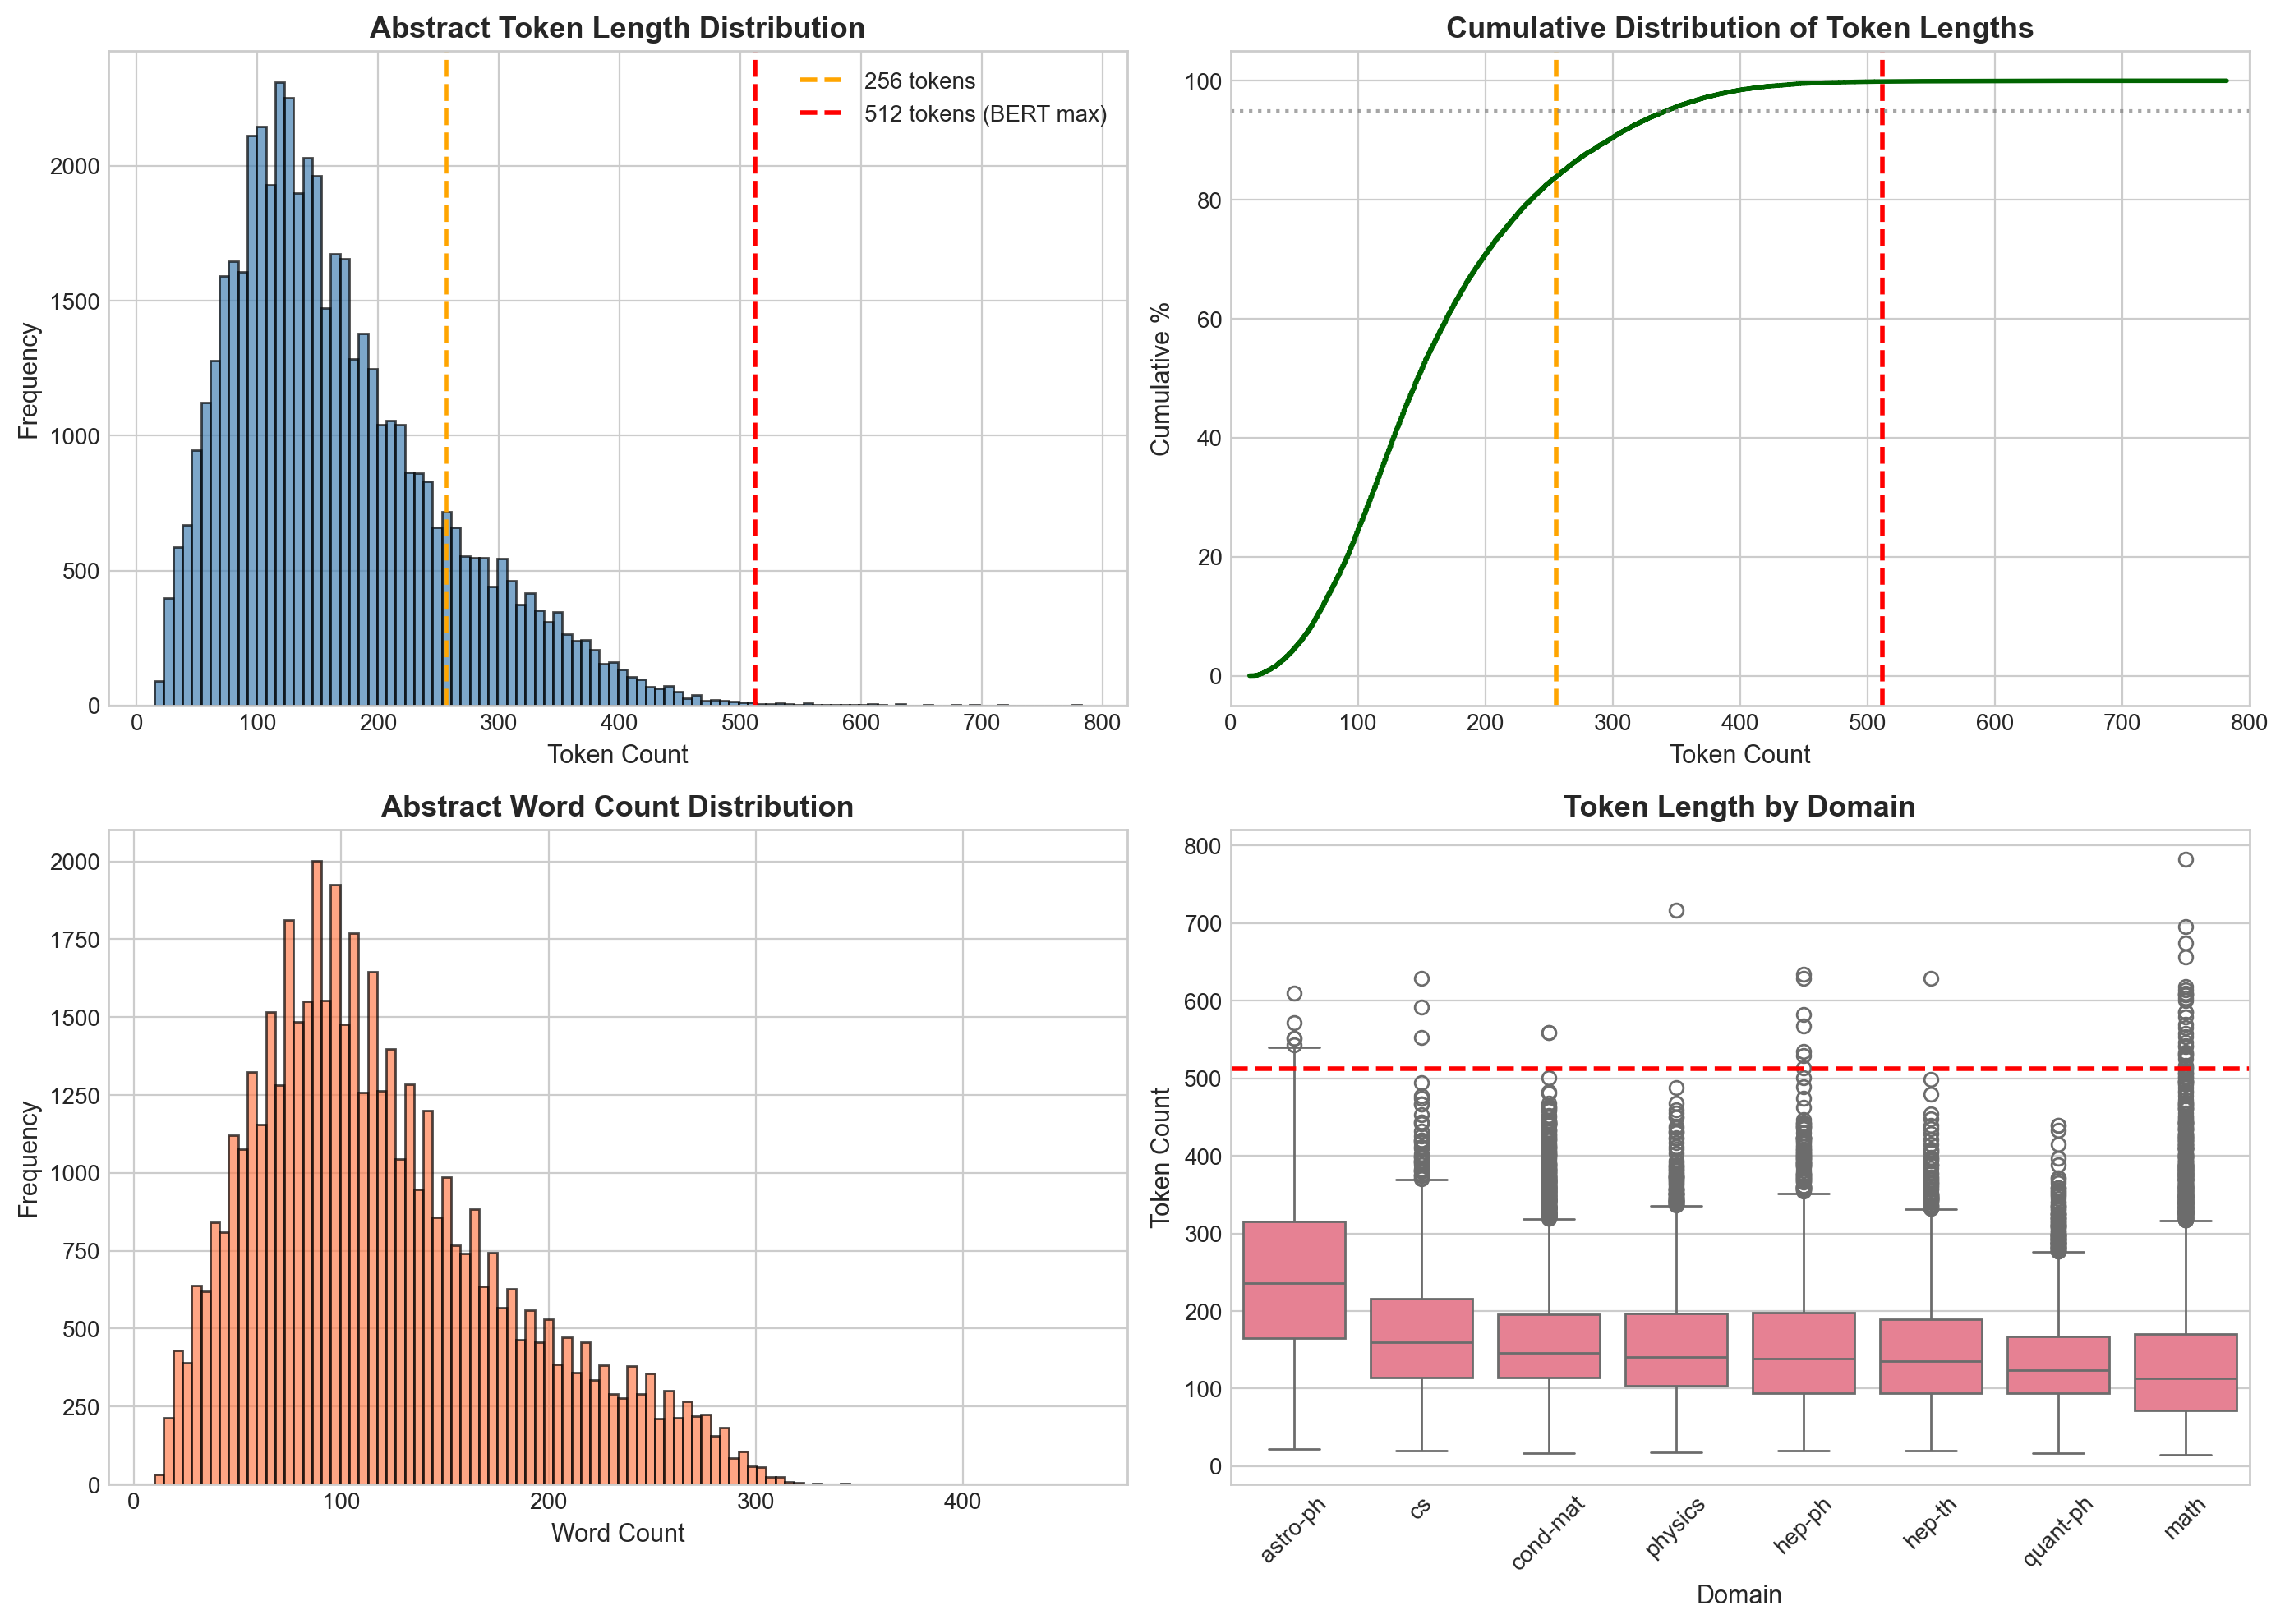


ABSTRACT LENGTH STATISTICS
  50th percentile: 147 tokens
  75th percentile: 215 tokens
  90th percentile: 297 tokens
  95th percentile: 343 tokens
  99th percentile: 419 tokens

  Abstracts <= 256 tokens: 84.0%
  Abstracts <= 512 tokens: 99.9%


In [23]:
# Visualize abstract length distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Token distribution
ax1 = axes[0, 0]
ax1.hist(sample_df['token_count'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=256, color='orange', linestyle='--', linewidth=2, label='256 tokens')
ax1.axvline(x=512, color='red', linestyle='--', linewidth=2, label='512 tokens (BERT max)')
ax1.set_xlabel('Token Count', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Abstract Token Length Distribution', fontsize=13, fontweight='bold')
ax1.legend()

# CDF
ax2 = axes[0, 1]
sorted_tokens = np.sort(sample_df['token_count'])
cdf = np.arange(1, len(sorted_tokens) + 1) / len(sorted_tokens) * 100
ax2.plot(sorted_tokens, cdf, linewidth=2, color='darkgreen')
ax2.axvline(x=256, color='orange', linestyle='--', linewidth=2)
ax2.axvline(x=512, color='red', linestyle='--', linewidth=2)
ax2.axhline(y=95, color='gray', linestyle=':', alpha=0.7)
ax2.set_xlabel('Token Count', fontsize=11)
ax2.set_ylabel('Cumulative %', fontsize=11)
ax2.set_title('Cumulative Distribution of Token Lengths', fontsize=13, fontweight='bold')
ax2.set_xlim(0, 800)

# Word count distribution
ax3 = axes[1, 0]
ax3.hist(sample_df['word_count'], bins=100, edgecolor='black', alpha=0.7, color='coral')
ax3.set_xlabel('Word Count', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Abstract Word Count Distribution', fontsize=13, fontweight='bold')

# Token count by domain (boxplot)
ax4 = axes[1, 1]
sample_df['domain'] = sample_df['primary_category'].apply(lambda x: x.split('.')[0] if '.' in x else x)
top_domains = sample_df['domain'].value_counts().head(8).index.tolist()
domain_subset = sample_df[sample_df['domain'].isin(top_domains)]
domain_order = domain_subset.groupby('domain')['token_count'].median().sort_values(ascending=False).index
sns.boxplot(data=domain_subset, x='domain', y='token_count', order=domain_order, ax=ax4)
ax4.axhline(y=512, color='red', linestyle='--', linewidth=2, label='BERT max')
ax4.set_xlabel('Domain', fontsize=11)
ax4.set_ylabel('Token Count', fontsize=11)
ax4.set_title('Token Length by Domain', fontsize=13, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'abstract_length_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print(f"\n{'='*60}")
print(f"ABSTRACT LENGTH STATISTICS")
print(f"{'='*60}")
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(sample_df['token_count'], p)
    print(f"  {p}th percentile: {val:.0f} tokens")

under_256 = (sample_df['token_count'] <= 256).mean() * 100
under_512 = (sample_df['token_count'] <= 512).mean() * 100
print(f"\n  Abstracts <= 256 tokens: {under_256:.1f}%")
print(f"  Abstracts <= 512 tokens: {under_512:.1f}%")

In [24]:
p95_tokens = np.percentile(sample_df['token_count'], 95)

print(f"""
MAX LENGTH RECOMMENDATION
{'='*60}
Finding: 95th percentile = {p95_tokens:.0f} tokens

RECOMMENDATION: max_length = 256

Rationale:
  - Covers ~{under_256:.0f}% of abstracts without truncation
  - 4x faster training vs 512 (attention is O(n²))
  - 4x smaller memory footprint per batch
  - Longer abstracts typically have key info in first ~200 tokens

Alternative: max_length = 384 for minimal truncation with moderate cost
""")


MAX LENGTH RECOMMENDATION
Finding: 95th percentile = 343 tokens

RECOMMENDATION: max_length = 256

Rationale:
  - Covers ~84% of abstracts without truncation
  - 4x faster training vs 512 (attention is O(n²))
  - 4x smaller memory footprint per batch
  - Longer abstracts typically have key info in first ~200 tokens

Alternative: max_length = 384 for minimal truncation with moderate cost



### 5.2 Text Quality Analysis

Check for issues that might affect model performance:

In [25]:
# Analyze text quality issues
def analyze_text_quality(text: str) -> dict:
    """Identify potential text quality issues."""
    return {
        'has_latex': bool(re.search(r'\$[^$]+\$|\\[a-zA-Z]+', text)),
        'has_urls': bool(re.search(r'http[s]?://|www\.', text)),
        'has_citations': bool(re.search(r'\[\d+\]|\(\d{4}\)', text)),
        'excessive_whitespace': bool(re.search(r'\s{3,}', text)),
        'has_html': bool(re.search(r'<[^>]+>', text)),
        'mostly_caps': sum(1 for c in text if c.isupper()) / max(len(text), 1) > 0.5,
    }

# Analyze sample
quality_results = [analyze_text_quality(row['abstract']) for _, row in sample_df.iterrows()]
quality_df = pd.DataFrame(quality_results)

print("TEXT QUALITY ANALYSIS")
print("="*60)
for col in quality_df.columns:
    pct = quality_df[col].mean() * 100
    print(f"  {col:25s}: {pct:5.1f}% of abstracts")

TEXT QUALITY ANALYSIS
  has_latex                :  27.8% of abstracts
  has_urls                 :   0.2% of abstracts
  has_citations            :   4.3% of abstracts
  excessive_whitespace     :   0.0% of abstracts
  has_html                 :   1.7% of abstracts
  mostly_caps              :   0.0% of abstracts


In [26]:
# Example abstracts with LaTeX (common in arxiv)
latex_examples = sample_df[quality_df['has_latex']].head(3)

print("\nExample abstracts with LaTeX:")
print("="*60)
for i, (_, row) in enumerate(latex_examples.iterrows(), 1):
    print(f"\n[{i}] Category: {row['primary_category']}")
    print(f"    {row['abstract'][:300]}...")


Example abstracts with LaTeX:

[1] Category: math.CO
    We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use it obtain a characterization of the family of $(k,\ell)$-sparse graphs and algorithmic solutions to a family of problems concerning tree decompositions of graphs. Special instances of sparse graphs appear in rigidity theory...

[2] Category: math.CA
    In this paper we show how to compute the $\Lambda_{\alpha}$ norm, $\alpha\ge 0$, using the dyadic grid. This result is a consequence of the description of the Hardy spaces $H^p(R^N)$ in terms of dyadic and special atoms....

[3] Category: cond-mat.mes-hall
    We study the two-particle wave function of paired atoms in a Fermi gas with tunable interaction strengths controlled by Feshbach resonance. The Cooper pair wave function is examined for its bosonic characters, which is quantified by the correction of Bose enhancement factor associated with the creat...


### 5.3 Preprocessing Decision

**Key Insight**: BERT/SciBERT tokenizers handle most preprocessing. Aggressive cleaning (removing LaTeX, lowercasing, etc.) can actually hurt performance. 

In [27]:
print(f"""
PREPROCESSING DECISION
{'='*60}
DECISION: MINIMAL PREPROCESSING

Applied:
  - Normalize whitespace (collapse multiple spaces/newlines)
  - Strip leading/trailing whitespace
  - Ensure UTF-8 encoding

NOT Applied (intentionally):
  - Lowercasing: SciBERT handles this; case can be informative
  - LaTeX removal: SciBERT was trained on scientific text with LaTeX
  - Stop word removal: destroys context needed by transformers
  - Stemming/Lemmatization: subword tokenization handles morphology
  - Special character removal: punctuation carries meaning

Rationale:
  - SciBERT was pre-trained on 1.14M scientific papers including LaTeX
  - Aggressive cleaning removes signal that the model has learned
  - Subword tokenization (WordPiece) handles OOV words naturally
""")


PREPROCESSING DECISION
DECISION: MINIMAL PREPROCESSING

Applied:
  - Normalize whitespace (collapse multiple spaces/newlines)
  - Strip leading/trailing whitespace
  - Ensure UTF-8 encoding

NOT Applied (intentionally):
  - Lowercasing: SciBERT handles this; case can be informative
  - LaTeX removal: SciBERT was trained on scientific text with LaTeX
  - Stop word removal: destroys context needed by transformers
  - Stemming/Lemmatization: subword tokenization handles morphology
  - Special character removal: punctuation carries meaning

Rationale:
  - SciBERT was pre-trained on 1.14M scientific papers including LaTeX
  - Aggressive cleaning removes signal that the model has learned
  - Subword tokenization (WordPiece) handles OOV words naturally



## 6. Temporal Analysis

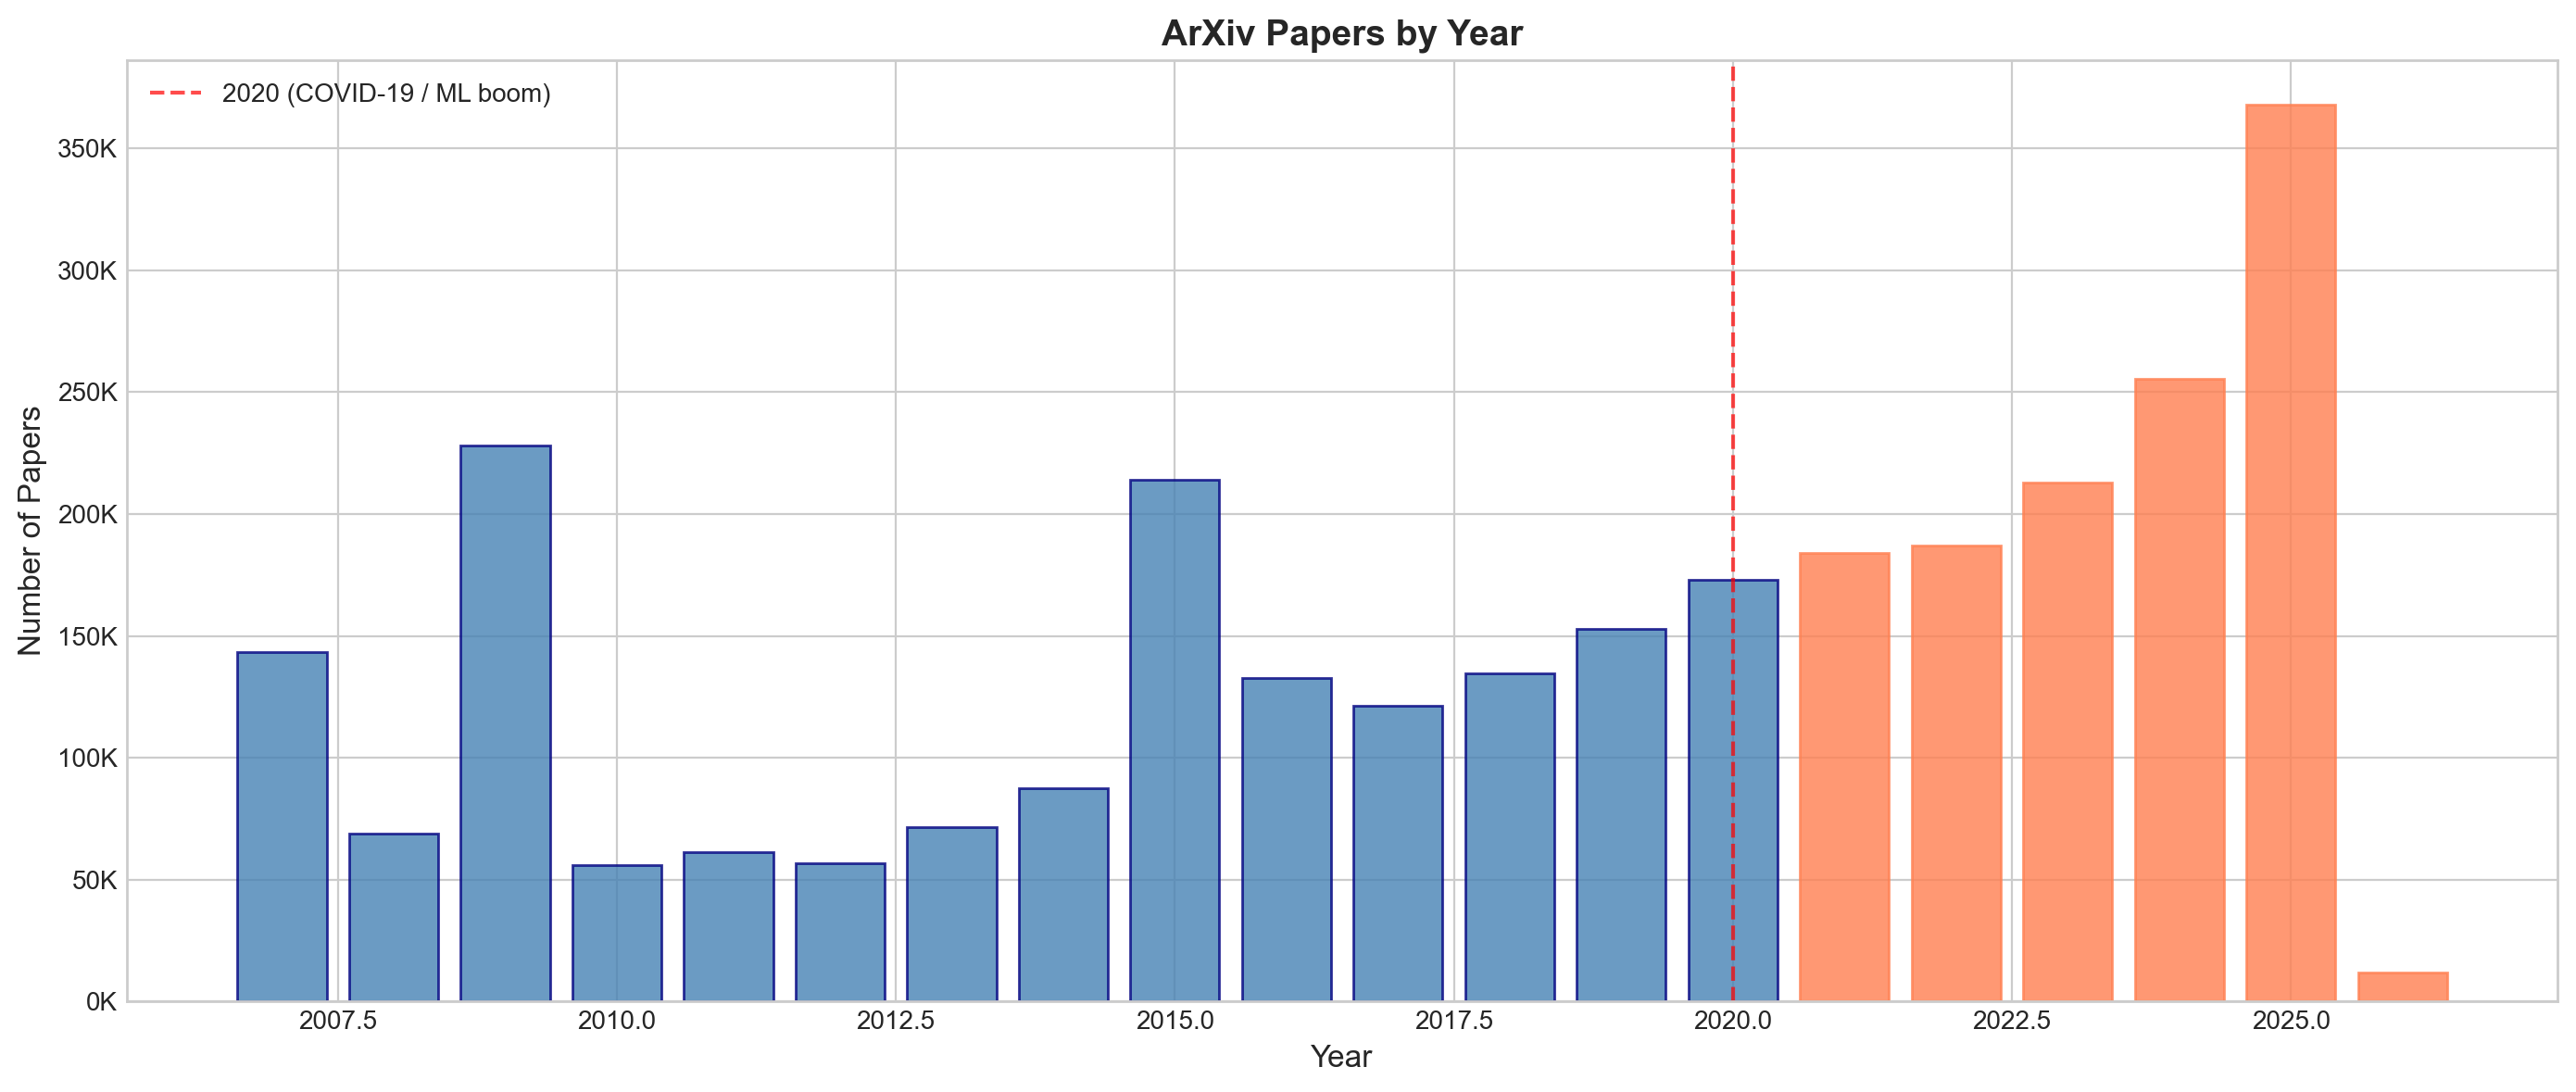


Papers by decade:
  1990s: 0 papers
  2000s: 440,411 papers
  2010s: 1,088,250 papers
  2020s: 1,391,962 papers


In [28]:
# Year distribution
year_df = pd.DataFrame([
    {'year': int(y), 'count': c}
    for y, c in sorted(years.items()) if y.isdigit() and int(y) >= 1990
])

fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(year_df['year'], year_df['count'], color='steelblue', edgecolor='navy', alpha=0.8)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Papers', fontsize=12)
ax.set_title('ArXiv Papers by Year', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e3:.0f}K'))

# Highlight recent years (likely in training data)
for bar in bars:
    if bar.get_x() >= 2020:
        bar.set_color('coral')

ax.axvline(x=2020, color='red', linestyle='--', alpha=0.7, label='2020 (COVID-19 / ML boom)')
ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'temporal_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPapers by decade:")
for decade_start in [1990, 2000, 2010, 2020]:
    decade_papers = sum(c for y, c in years.items() if y.isdigit() and decade_start <= int(y) < decade_start + 10)
    print(f"  {decade_start}s: {decade_papers:,} papers")

## 7. Data Sampling Strategy

### 7.1 Train/Validation/Test Split Strategy

In [31]:
print(f"""
DATA SPLIT STRATEGY
{'='*60}
Split Method: HASH-BASED DETERMINISTIC

Implementation:
  - hash(paper_id) % 100 < 80  Train (80%)
  - hash(paper_id) % 100 < 90  Validation (10%)
  - Otherwise                  Test (10%)

Why hash-based (not random):
  - Deterministic: same paper always in same split
  - Reproducible: no need to store split files
  - Scalable: works with streaming (no need to load all data)
  - Consistent: adding new papers doesn't change existing assignments
""")


DATA SPLIT STRATEGY
Split Method: HASH-BASED DETERMINISTIC

Implementation:
  - hash(paper_id) % 100 < 80  Train (80%)
  - hash(paper_id) % 100 < 90  Validation (10%)
  - Otherwise                  Test (10%)

Why hash-based (not random):
  - Deterministic: same paper always in same split
  - Reproducible: no need to store split files
  - Scalable: works with streaming (no need to load all data)
  - Consistent: adding new papers doesn't change existing assignments



In [32]:
def get_split(paper_id: str, train_pct: int = 80, val_pct: int = 10) -> str:
    """
    Deterministic split assignment based on paper ID hash.
    
    Args:
        paper_id: Unique paper identifier
        train_pct: Percentage for training (default 80)
        val_pct: Percentage for validation (default 10)
    
    Returns:
        'train', 'val', or 'test'
    """
    hash_val = int(hashlib.md5(paper_id.encode()).hexdigest(), 16) % 100
    
    if hash_val < train_pct:
        return 'train'
    elif hash_val < train_pct + val_pct:
        return 'val'
    else:
        return 'test'

# Verify split distribution on sample
split_counts_verify = Counter()
for paper in stream_arxiv_papers(ARXIV_JSON_PATH, max_papers=100000, progress=False):
    split_counts_verify[get_split(paper.id)] += 1

print("Split verification (100K sample):")
total = sum(split_counts_verify.values())
for split, count in sorted(split_counts_verify.items()):
    print(f"  {split:5s}: {count:,} ({count/total*100:.1f}%)")

Split verification (100K sample):
  test : 9,992 (10.0%)
  train: 79,943 (79.9%)
  val  : 10,065 (10.1%)


### 7.2 Create Hugging Face Dataset

- Efficient Arrow format for fast loading
- Built-in support for shuffling, batching, and streaming
- Easy integration with `Trainer` and `torch.utils.data.DataLoader`
- Optional upload to Hugging Face Hub

In [34]:
def create_hf_dataset(
    input_path: Path,
    output_dir: Path,
    selected_categories: List[str],
    max_samples_per_category: Optional[int] = None,
    progress: bool = True
) -> DatasetDict:
    """
    Create a Hugging Face DatasetDict from raw ArXiv data.
    
    Args:
        input_path: Path to raw arxiv JSON
        output_dir: Directory for output HF dataset
        selected_categories: List of categories to include
        max_samples_per_category: Optional cap per category (for balancing)
        progress: Show progress bar
    
    Returns:
        DatasetDict with train, val, test splits
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    category_set = set(selected_categories)
    
    # Collect records per split
    split_records = {'train': [], 'val': [], 'test': []}
    category_counts_per_split = defaultdict(lambda: defaultdict(int))
    
    for paper in stream_arxiv_papers(input_path, progress=progress):
        # Filter to selected categories
        valid_categories = [c for c in paper.categories if c in category_set]
        
        if not valid_categories:
            continue
        
        # Determine split
        split = get_split(paper.id)
        
        # Check category caps if specified
        if max_samples_per_category and split == 'train':
            if all(
                category_counts_per_split[split][c] >= max_samples_per_category
                for c in valid_categories
            ):
                continue
        
        # Create record
        record = {
            'id': paper.id,
            'title': paper.title,
            'abstract': paper.abstract,
            'categories': valid_categories,
            'primary_category': valid_categories[0],
        }
        
        split_records[split].append(record)
        
        # Update category counts
        for cat in valid_categories:
            category_counts_per_split[split][cat] += 1
    
    # Define features schema
    features = Features({
        'id': Value('string'),
        'title': Value('string'),
        'abstract': Value('string'),
        'categories': Sequence(Value('string')),
        'primary_category': Value('string'),
    })
    
    # Create DatasetDict
    dataset_dict = DatasetDict({
        split: Dataset.from_list(records, features=features)
        for split, records in split_records.items()
    })
    
    # Save to disk in Arrow format
    dataset_dict.save_to_disk(output_dir)
    
    # Save metadata
    stats = {
        'split_counts': {split: len(records) for split, records in split_records.items()},
        'category_counts_per_split': {
            split: dict(counts)
            for split, counts in category_counts_per_split.items()
        },
        'selected_categories': selected_categories,
        'num_categories': len(selected_categories),
    }
    
    with open(output_dir / 'dataset_stats.json', 'w') as f:
        json.dump(stats, f, indent=2)
    
    return dataset_dict

In [35]:
# Create the HF dataset
print("Creating Hugging Face dataset...")
print(f"Selected categories: {len(SELECTED_CATEGORIES)}")
print(f"Output directory: {HF_DATASET_DIR}")
print("\nThis will take 5-10 minutes...\n")

arxiv_dataset = create_hf_dataset(
    input_path=ARXIV_JSON_PATH,
    output_dir=HF_DATASET_DIR,
    selected_categories=SELECTED_CATEGORIES,
    progress=True
)

# Print summary
print("\n" + "="*60)
print("DATASET CREATION COMPLETE")
print("="*60)
for split, ds in arxiv_dataset.items():
    print(f"  {split:5s}: {len(ds):>10,} papers")

split_counts = {split: len(ds) for split, ds in arxiv_dataset.items()}

Creating Hugging Face dataset...
Selected categories: 50
Output directory: ../data/hf_dataset

This will take 5-10 minutes...



Loading papers:   0%|          | 0/2500000 [00:00<?, ?it/s]


Loaded 2,920,623 papers
Skipped: {'no_abstract': 0, 'short_abstract': 6840, 'no_categories': 0}


Saving the dataset (0/5 shards):   0%|          | 0/1946270 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/243997 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/243107 [00:00<?, ? examples/s]


DATASET CREATION COMPLETE
  train:  1,946,270 papers
  val  :    243,997 papers
  test :    243,107 papers


### 7.3 Verify Dataset Quality

In [36]:
# Load dataset from disk (demonstrates loading)
print("Loading dataset from disk...")
loaded_dataset = load_from_disk(HF_DATASET_DIR)

print(f"\nDataset structure:")
print(loaded_dataset)

print(f"\nFeatures:")
print(loaded_dataset['train'].features)

Loading dataset from disk...

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'abstract', 'categories', 'primary_category'],
        num_rows: 1946270
    })
    val: Dataset({
        features: ['id', 'title', 'abstract', 'categories', 'primary_category'],
        num_rows: 243997
    })
    test: Dataset({
        features: ['id', 'title', 'abstract', 'categories', 'primary_category'],
        num_rows: 243107
    })
})

Features:
{'id': Value('string'), 'title': Value('string'), 'abstract': Value('string'), 'categories': List(Value('string')), 'primary_category': Value('string')}


In [37]:
# Explore samples
print("Sample records from each split:")
print("="*60)

for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()} split:")
    sample = loaded_dataset[split][0]
    print(f"  ID: {sample['id']}")
    print(f"  Title: {sample['title'][:80]}...")
    print(f"  Categories: {sample['categories']}")
    print(f"  Primary: {sample['primary_category']}")
    print(f"  Abstract: {sample['abstract'][:150]}...")

Sample records from each split:

TRAIN split:
  ID: 0704.0001
  Title: Calculation of prompt diphoton production cross sections at Tevatron and
  LHC e...
  Categories: ['hep-ph']
  Primary: hep-ph
  Abstract: A fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pairs at hadron colliders. A...

VAL split:
  ID: 0704.0009
  Title: The Spitzer c2d Survey of Large, Nearby, Insterstellar Clouds. IX. The
  Serpens...
  Categories: ['astro-ph']
  Primary: astro-ph
  Abstract: We discuss the results from the combined IRAC and MIPS c2d Spitzer Legacy observations of the Serpens star-forming region. In particular we present a ...

TEST split:
  ID: 0704.0016
  Title: Lifetime of doubly charmed baryons...
  Categories: ['hep-ph']
  Primary: hep-ph
  Abstract: In this work, we evaluate the lifetimes of the doubly charmed baryons $\Xi_{cc}^{+}$, $\Xi_{cc}^{++}$ and $\Omega_{cc}^{+}$. We carefully calculate th...


In [38]:
# Load dataset stats and verify split ratios
with open(HF_DATASET_DIR / 'dataset_stats.json', 'r') as f:
    dataset_stats = json.load(f)

# Visualize category distribution per split
train_cats = dataset_stats['category_counts_per_split']['train']
val_cats = dataset_stats['category_counts_per_split']['val']
test_cats = dataset_stats['category_counts_per_split']['test']

# Create comparison dataframe
comparison_data = []
for cat in SELECTED_CATEGORIES:
    comparison_data.append({
        'category': cat,
        'train': train_cats.get(cat, 0),
        'val': val_cats.get(cat, 0),
        'test': test_cats.get(cat, 0)
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df['total'] = comparison_df['train'] + comparison_df['val'] + comparison_df['test']
comparison_df = comparison_df.sort_values('total', ascending=False)

# Verify split ratios are consistent
comparison_df['train_pct'] = comparison_df['train'] / comparison_df['total'] * 100
comparison_df['val_pct'] = comparison_df['val'] / comparison_df['total'] * 100
comparison_df['test_pct'] = comparison_df['test'] / comparison_df['total'] * 100

print("Split ratio consistency check (should be ~80/10/10):")
print(f"  Train: {comparison_df['train_pct'].mean():.1f}% +/- {comparison_df['train_pct'].std():.1f}%")
print(f"  Val:   {comparison_df['val_pct'].mean():.1f}% +/- {comparison_df['val_pct'].std():.1f}%")
print(f"  Test:  {comparison_df['test_pct'].mean():.1f}% +/- {comparison_df['test_pct'].std():.1f}%")

Split ratio consistency check (should be ~80/10/10):
  Train: 80.0% +/- 0.2%
  Val:   10.0% +/- 0.1%
  Test:  10.0% +/- 0.1%


## 8. Summary & Next Steps

In [41]:
print(f"""
EDA SUMMARY
{'='*60}

DATASET OVERVIEW
  Total papers:        {total_papers:>12,}
  Selected categories: {len(SELECTED_CATEGORIES):>12}
  Multi-label rate:    {multi_label/total_papers*100:>11.1f}%

PROCESSED DATASET (Hugging Face Format)
  Train samples:       {split_counts['train']:>12,}
  Val samples:         {split_counts['val']:>12,}
  Test samples:        {split_counts['test']:>12,}

KEY DECISIONS
  - Problem: Multi-label classification
  - Max length: 256 tokens (covers ~{under_256:.0f}% without truncation)
  - Preprocessing: Minimal (whitespace normalization only)
  - Split method: Hash-based deterministic (80/10/10)
  - Category selection: {len(SELECTED_CATEGORIES)} categories with >={MIN_SAMPLES_THRESHOLD:,} samples
  - Storage format: Hugging Face Dataset (Arrow)

FILES CREATED
  - {HF_DATASET_DIR}/ (HF Dataset with train/val/test splits)
  - data/processed/category_config.json
  - data/hf_dataset/dataset_stats.json
""")


EDA SUMMARY

DATASET OVERVIEW
  Total papers:           2,920,623
  Selected categories:           50
  Multi-label rate:           47.7%

PROCESSED DATASET (Hugging Face Format)
  Train samples:          1,946,270
  Val samples:              243,997
  Test samples:             243,107

KEY DECISIONS
  - Problem: Multi-label classification
  - Max length: 256 tokens (covers ~84% without truncation)
  - Preprocessing: Minimal (whitespace normalization only)
  - Split method: Hash-based deterministic (80/10/10)
  - Category selection: 50 categories with >=5,000 samples
  - Storage format: Hugging Face Dataset (Arrow)

FILES CREATED
  - ../data/hf_dataset/ (HF Dataset with train/val/test splits)
  - data/processed/category_config.json
  - data/hf_dataset/dataset_stats.json



In [43]:
# Save configuration for training pipeline
CONFIGS_DIR = PROJECT_ROOT / 'configs'
CONFIGS_DIR.mkdir(exist_ok=True)

training_config = {
    'data': {
        'hf_dataset_path': str(HF_DATASET_DIR),
        'category_config_path': str(PROCESSED_DATA_DIR / 'category_config.json'),
        'num_classes': len(SELECTED_CATEGORIES),
        'multilabel': True
    },
    'model': {
        'pretrained_name': 'allenai/scibert_scivocab_uncased',
        'max_length': 256,
        'dropout': 0.1
    },
    'training': {
        'batch_size': 32,
        'learning_rate': 2e-5,
        'warmup_ratio': 0.1,
        'epochs': 5,
        'early_stopping_patience': 2,
        'use_focal_loss': True,
        'focal_gamma': 2.0
    }
}

with open(CONFIGS_DIR / 'training_config.json', 'w') as f:
    json.dump(training_config, f, indent=2)

print(f"Saved training configuration to {CONFIGS_DIR / 'training_config.json'}")

Saved training configuration to ../configs/training_config.json
